<a href="https://colab.research.google.com/github/marvinmouroum/cv-heart-rate-measurement/blob/master/cv_heart_rate_measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face detection

### Initialize the Code

In [0]:
import os
import cv2
import numpy as np
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
from googleapiclient.http import MediaIoBaseDownload
from google.colab import drive as gdrive

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import statistics

from IPython.display import Math, HTML

In [258]:
gdrive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Project/'
source_path = 'gdrive/My Drive/cohface/'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Define paths
prototxt_path = os.path.join(root_path + 'deploy.prototxt')
caffemodel_path = os.path.join(root_path + 'weights.caffemodel')

prototxt_path_id = '1-zfDOBY5fVcEzwii2JlrIDFyhLyvu5m5'
caffemodel_path_id = '1jxuFoSukXr78rLfBgkLwn2qiWNUfoONf'
image_id = '1wb8whYMorQNU2YvmHZsZGFeUTDc-95DN'

downloaded = drive.CreateFile({'id': prototxt_path_id})
downloaded.GetContentFile('deploy.prototxt')

downloaded = drive.CreateFile({'id': caffemodel_path_id})
downloaded.GetContentFile('weights.caffemodel')

# Read the model
model = cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)

### Proof of Concept

Not needed for running for the detection

In [0]:
!ls gdrive/My\ Drive/Project

deploy.prototxt  example.jpg  weights.caffemodel


In [0]:
# Create directory 'updated_images' if it does not exist
if not os.path.exists('updated_images'):
	print("New directory created")
	os.makedirs('updated_images')

New directory created


In [0]:
# Create directory 'faces' if it does not exist
if not os.path.exists('faces'):
	print("New directory created")
	os.makedirs('faces')

New directory created


In [0]:
!ls images

ls: cannot access 'images': No such file or directory


In [0]:
# Loop through all images and save images with marked faces
for file in os.listdir('images'):
	file_name, file_extension = os.path.splitext(file)
	if (file_extension in ['.png','.jpg']):
		print("Image path: {}".format('images/' + file))

FileNotFoundError: ignored

In [0]:
image = cv2.imread('images/' + file)

(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

model.setInput(blob)
detections = model.forward()

In [0]:
# Create frame around face
for i in range(0, detections.shape[2]):
  box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
  (startX, startY, endX, endY) = box.astype("int")

  confidence = detections[0, 0, i, 2]

  # If confidence > 0.5, show box around face
  if (confidence > 0.5):
    cv2.rectangle(image, (startX, startY), (endX, endY), (255, 255, 255), 2)

cv2.imwrite('updated_images/' + file, image)
print("Image " + file + " converted successfully")

In [0]:
count = 0
# Identify each face
for i in range(0, detections.shape[2]):
  box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
  (startX, startY, endX, endY) = box.astype("int")

  confidence = detections[0, 0, i, 2]

  # If confidence > 0.5, save it as a separate file
  if (confidence > 0.5):
    count += 1
    frame = image[startY:endY, startX:endX]
    cv2.imwrite('faces/' + str(i) + '_' + file, frame)

In [0]:
!ls updated_images

In [0]:
from IPython.display import Image
display(Image('updated_images/image.jpg'))
display(Image('faces/0_image.jpg'))

In [0]:
downloaded = drive.CreateFile({'id': '10d5-_YC2lX09LfnbbvraW0GoAKeqXUDu'})
downloaded.GetContentFile('videos/data.avi')

## Video Implementation

### This sections creates a local document structure in order to 

*   save a video locally in *temp_video*
*   extract the face and save the image with bounding box locally in *bounding*
*   extract the face and save it in a specified folder *faces/videoID*
*   resize the face and save it in the directory *resized/videoID






In [0]:
#This will clean the creates data
def clean(temp='temp_video',bound='bounding',faces='faces',resized='resized'):
  !rm -r $temp
  !rm -r $bound
  !rm -r $faces
  !rm -r $resized 

#This will create all the necessary directories in order to perform the preprocessing
def create_infrastructure(temp='temp_video',bound='bounding',faces='faces',resized='resized'):
  !mkdir $temp
  !mkdir $bound
  !mkdir $faces
  !mkdir $resized
  !mkdir 'gdrive/My Drive/cohface/frames'

#This will copy a video from the drive in the respective directory and create a folder dedicated to it's id
def getVideo(path,id,faces='faces',bound='bounding',resized='resized',temp='temp_video'):
  !mkdir $faces/$id
  !mkdir $bound/$id
  !mkdir $resized/$id
  filetype = path.split('.')[-1]
  target   = "'" + temp + '/' + id + '.' + filetype + "'"
  source   = "'" + path + "'"
  #print("!cp" + " " + source + " " + target)
  !cp $path $target
  return temp + '/' + id + '.' + filetype

In [0]:
def resize_img(img,destination):
  # Create square images from pepes by adding black margins preserving original aspect ratio
  #Importing modules opencv + numpy
  import cv2
  import numpy as np

  w = 128
  h = 192

  #Reading an image (you can use PNG or JPG)
  name = img
  img = cv2.imread(img)

  if(img.shape[0] > h or img.shape[1] > w):
    #print("bigger image detected")
    img = cv2.resize(img,(w,h))

  if img is None:
    print("Could not read image ", name)
    return False

  #Creating a dark square with NUMPY  
  f = np.zeros((h,w,3),np.uint8)

  #Getting the centering position
  ax,ay = (w - img.shape[1])//2,(h - img.shape[0])//2

  #Pasting the 'image' in a centering position
  f[ay:img.shape[0]+ay,ax:ax+img.shape[1]] = img
  

  #Saving the image
  f = cv2.resize(f,(w,h),interpolation=cv2.INTER_NEAREST)
  cv2.imwrite(destination,f)
  cv2.destroyAllWindows() 
  return True

In [0]:
def find_face(image,id,fileID,bound='bounding',faces='faces'):

  count = 0

  (h, w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

  model.setInput(blob)
  detections = model.forward()
  # Create frame around face
  for i in range(0, detections.shape[2]):
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")

    confidence = detections[0, 0, i, 2]

    # If confidence > 0.5, show box around face
    if (confidence > 0.5):
      cv2.rectangle(image, (startX, startY), (endX, endY), (255, 255, 255), 2)
      #print(endX-startX)
      #print(endY-startY)
    
  cv2.imwrite( bound + '/' + id + '/' + fileID + '.png', image)

    # Identify each face#
  for i in range(0, detections.shape[2]):
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")

    confidence = detections[0, 0, i, 2]

    # If confidence > 0.5, save it as a separate file
    if (confidence > 0.5):
      count += 1
      frame = image[startY:endY, startX:endX]
      #print(faces + '/' + id + '/' + fileID + '.png')
      cv2.imwrite( faces + '/' + id + '/' + fileID + '.png', frame)
      #cv2_imshow(frame)
      resize_img(faces + '/' + id + '/' + fileID + '.png','resized/' + id + '/' + fileID + '.png')
  
  if count == 0:
    print("did not find face for " , fileID)

In [0]:
def analyze_video(video,id,temp='temp_video'):

  # load video stream
  VIDEO_STREAM =  temp + '/' + video

  # Initialize the video stream and pointer to output video file
  vs = cv2.VideoCapture(VIDEO_STREAM)
  writer = None
  vs.set(cv2.CAP_PROP_POS_FRAMES, 1);
  length = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
  print( "frame has length of " , length )
  i = 0
  while i < length:
    # read the next frame from the file
    (grabbed, frame) = vs.read()
    i += 1
    # If the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
      print("Not grabbed.")
      break;
    newID = id + str(i)
    find_face(frame,id,newID)
    if i%100 == 0:
      print(i)
    #break


### This section generates frames only of the face and saves them in a folder on the drive and local storage

In [264]:
from google.colab.patches import cv2_imshow

def save_face_for(subject,folder):
  myid = str(subject)+'_'+str(folder)
  clean()
  create_infrastructure()
  filepath = getVideo('gdrive/My\ Drive/cohface/1/0/data.avi',myid)
  filename = filepath.split("/")[-1]
  analyze_video(filename,myid)

  destination = 'gdrive/My\ Drive/cohface/frames/' + myid
  _destination = "'" + 'gdrive/My Drive/cohface/frames/' + myid + "'" 
  _source = "'resized/"+myid+"/.'"
  !mkdir $destination
  !cp -a $_source $_destination

save_face_for(1,1)

mkdir: cannot create directory ‘gdrive/My Drive/cohface/frames’: File exists
frame has length of  1205
100
200
300
400
500
600
700
800
900
1000
1100
1200
Not grabbed.
mkdir: cannot create directory ‘gdrive/My Drive/cohface/frames/1_1’: File exists


In [0]:
def getVideos(random, vtype, nb, path, videosPaths):
    if nb > len(videosPaths):
      for file in os.listdir(path): # Get files and directories of the directory
          _, currVidType = os.path.splitext(file)
          if os.path.isdir(file): # This is a directory
              getVideos(random, vtype, nb, path+'/'+file, videosPaths) 
          elif currVidType == '.'+vtype: # This is a file with the good video type
              videosPaths.append(path+'/'+file)
    return videosPaths 

In [0]:
def script(random, vtype, nb, directories):
  videosPaths = []
  if len(directories)==0:
    currentdirpath = os.getcwd()
    videosPaths = getVideos(random, vtype, nb, currentdirpath, videosPaths)
  else: 
    # there is no directory	 
    for i in range(0,len(directories)):
        videosPaths += getVideos(random, vtype, nb, directories[i],videosPaths)  
       
  return videosPaths

## Here will be the dataloader that organizes the dataset for our training

### Insights

This section is for reading the labeled data, plotting and analyzing it.

(15536,)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


[38.24775382 38.23002293 38.21243272 ... 35.48718827 35.49861642
 35.51022736]


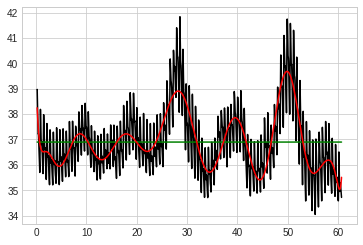

In [267]:
import h5py
#library documentation: http://docs.h5py.org/en/stable/quick.html

f = h5py.File('gdrive/My Drive/cohface/36/1/data.hdf5', 'r')
list(f.keys())

dset = f['pulse']
tset = f['time'] #in seconds

print(dset.shape)
tset.shape
int(tset[-1])

avg = statistics.mean(dset)
sd = statistics.stdev(dset)

srt = 50
stp = dset.size
avgV = [avg] * (stp-srt)

#have a look at the data
plt.plot(tset[srt:stp], dset[srt:stp], '-', color='black');
plt.plot(tset[srt:stp], avgV, '-', color='green');

# calculate polynomial
z = np.polyfit(tset[srt:stp], dset[srt:stp], 25)
f = np.poly1d(z)

y_new = f(tset[srt:stp])
print(y_new)
plt.plot(tset[srt:stp], y_new, '-', color='red');


### Methods

This section contains methods to extract the real HR from the raw BVP data. Some methods will extract the HR for every other second, others will extract the HR for every frame. In the latter case missing fields will be filled by existing values closed by.
Cleaning is performed to keep the HR values between 40 and 240 (like in the Paper) Wrong values will be substituted by the mean value.

In [0]:
def clean_hr_vector(vector):
  print("cleaning")

  cleaned = list(filter(lambda x: x < 240, vector))
  cleaned = list(filter(lambda x: x > 40, vector))
  mean = statistics.mean(cleaned)

  if vector[0] > 240 or vector[0] < 40:
    vector[0] = int(mean)

  for i in range(1,vector.size-1):

    if i % 500 == 0:
      print(str(int(100*i/vector.size)) + "%")
    
    if vector[i] == 0 and vector[i+1] != 0:
      vector[i] = int((vector[i-1]+vector[i+1])/2)
    
    if vector[i] > 240 or vector[i] < 40:
      vector[i] = int(mean)

  print("100%")
  return vector



In [0]:
def extract_hr(xset,yset,start=1,end=2000, plot=False):
   old_value = yset[start-1]
   old_t = xset[start-1]
   old_abs_t = 0

   vector = np.zeros((int(xset[-1])*2))

   valley = False

   nu = statistics.mean(yset)
   std = statistics.stdev(yset)

   # calculate polynomial
   z = np.polyfit(xset[50:-1], yset[50:-1], 25)
   f = np.poly1d(z)
  
   y_new = f(xset)
   if plot:
    plt.plot(xset[50:-1], y_new[50:-1], '-', color='red');
    plt.show()


   for i in range(start,end):
     
     if i >= yset.size or i >= y_new.size:
       break

     if yset[i] < y_new[i] and not valley:
        valley = True

     if yset[i] > y_new[i]+std*0.5 and valley:
        valley = False
        
        #print(str(int(60/(xset[i]-old_t))) + " bpm at " + str(old_abs_t) )
        if old_abs_t == int(xset[-1]):
          break

        hr = int(60/(xset[i]-old_t))

        if(int(2*old_abs_t) >= len(vector)):
          continue
        
        if vector[int(2*old_abs_t)] == 0:
          vector[int(2*old_abs_t)] = hr
        elif abs((vector[int(2*old_abs_t)-1]-vector[int(2*old_abs_t)])/vector[int(2*old_abs_t)-1]) > abs((vector[int(2*old_abs_t)-1]-hr)/vector[int(2*old_abs_t)-1]):
          vector[int(2*old_abs_t)] = hr


        old_t = xset[i]

     if int(2*xset[i])/2 > old_abs_t:
       old_abs_t = int(2*xset[i])/2

   return clean_hr_vector(vector)

def hr_frame_label(xset,yset,start=1,end=2000, plot=False):
   old_value = yset[start-1]
   old_t = xset[start-1]

   vector = np.zeros(xset.size)

   valley = False

   lastI = 0

   nu = statistics.mean(yset)
   std = statistics.stdev(yset)

   # calculate polynomial
   z = np.polyfit(xset[50:-1], yset[50:-1], 25)
   f = np.poly1d(z)
  
   y_new = f(xset)
   if plot:
    plt.plot(xset[50:-1], y_new[50:-1], '-', color='red');
    plt.show()


   for i in range(start,end):
     
     if i >= yset.size or i >= y_new.size:
       break

     if yset[i] < y_new[i] and not valley:
        valley = True

     if yset[i] > y_new[i]+std*0.25 and valley:
        valley = False

        hr = int(60/(xset[i]-old_t))
        #print(str(xset[i])+"-"+str(old_t)+"="+str(hr))
        
        if vector[i] == 0:

          if i == 0:
            vector[i] = hr
          else:
            vector[lastI:i+1] = [hr] * (i-lastI+1)

          lastI = i
        elif abs((vector[i-1]-vector[i])/vector[i-1]) > abs((vector[i-1]-hr)/vector[i-1]):
          vector[lastI:i+1] = [hr] * (i-lastI+1)
          lastI = i
        #print(str(i)+": " + str(vector[i]) + " - " + str(hr))


        old_t = xset[i]

   return clean_hr_vector(vector)
  
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks

def peak_hr_estimation(xset,yset,start=1,end=2000, plot=False):
  data = yset[start:end]
  times = xset[start:end]

  peaks, _ = find_peaks(data, height=0)
  avg = statistics.mean(data)
  avgV = [avg]*len(list(data))
  
  z = np.polyfit(times,data, 5)
  f = np.poly1d(z)

  hr_times = []
  hr = []

  for i in range(0,len(data[list(peaks)])):
    if data[list(peaks)][i] > f(times[list(peaks)][i])*1.01:
      #print(str(times[list(peaks)][i]) + ": " + str(data[list(peaks)][i]) + ">" + str(f(times[list(peaks)][i])*1.02))
      hr_times.append(times[list(peaks)][i])
      if len(hr_times) > 1:
        hr.append(int(60/(hr_times[-1] - hr_times[-2])))

#  print(hr)


  if plot:
    plt.plot(times,data)
    plt.plot(times,avgV,'-',color='green')
    plt.plot(times,f(times),'-',color='red')
    plt.plot(times[list(peaks)], data[list(peaks)],'x')
    plt.show()

  hr_times.pop()
  return [hr_times,hr] 


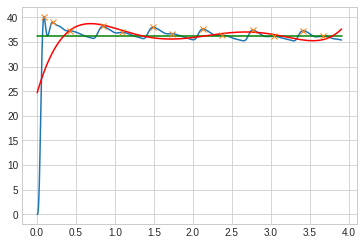

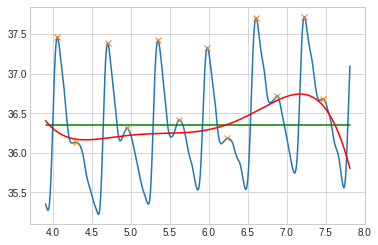

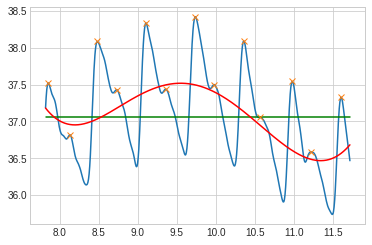

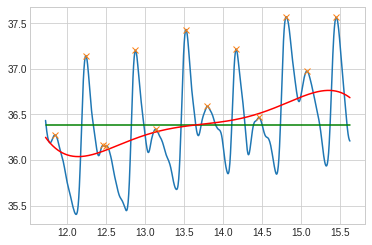

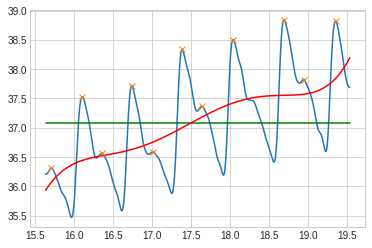

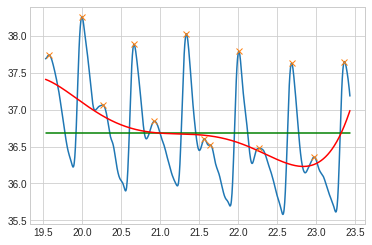

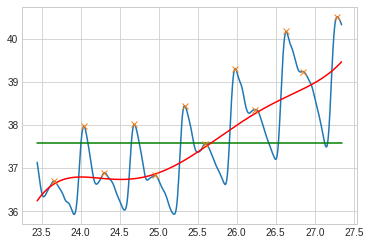

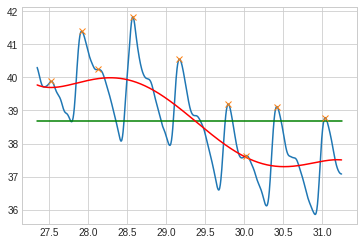

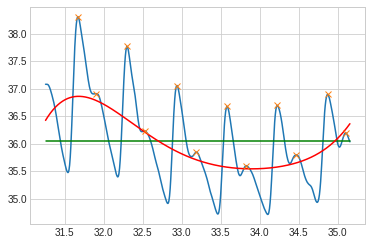

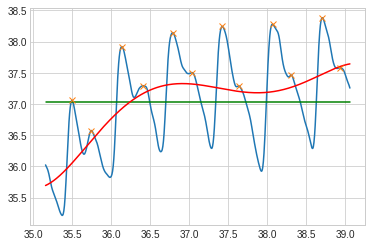

In [256]:
#extract_hr(tset,dset,0,16000)
rates = []
times = []
for i in range(0,10000,1000):
  res = peak_hr_estimation(tset[i:i+1000],dset[i:i+1000],0,1999,True)
  rates += res[1]
  times += res[0]


In [255]:
print(rates)
print(clean_hr_vector(np.array(rates)))

[111, 46, 247, 152, 93, 93, 232, 93, 93, 94, 96, 97, 95, 96, 94, 96, 96, 96, 94, 92, 93, 93, 93, 94, 93, 91, 91, 90, 89, 89, 89, 88, 88, 92, 93, 92, 91, 284, 134, 91, 100, 96, 96, 97, 94, 94, 93, 93, 93, 94, 91, 94, 93, 94]
cleaning
100%
[111  46 103 152  93  93 232  93  93  94  96  97  95  96  94  96  96  96
  94  92  93  93  93  94  93  91  91  90  89  89  89  88  88  92  93  92
  91 103 134  91 100  96  96  97  94  94  93  93  93  94  91  94  93  94]


In [0]:
def heartRateForSubjects(from_=1,to=40,folder_start=0,folder_end=3, plot = False):
  rates = [[[0]]* (folder_end-folder_start)] * (to-from_)
  print(rates)
  for i in range(from_,to):
    for j in range(folder_start,folder_end):
      print("\nsubject " + str(i) + " set: " + str(j) + "\n_________________")
      f = h5py.File('gdrive/My Drive/cohface/' + str(i) + '/'+ str(j) +'/data.hdf5', 'r')
      dset = f['pulse']
      tset = f['time']
      if plot:
        plt.plot(tset[50:-1], dset[50:-1], '-', color='black');
      rates[i-from_][j-folder_start] = extract_hr(tset,dset,0,16000,plot)
  return rates

def heartRateForFrames(from_=1,to=40,folder_start=0,folder_end=3, plot = False):
  rates = [[[0]]* (folder_end-folder_start)] * (to-from_)
  print(rates)
  for i in range(from_,to):
    for j in range(folder_start,folder_end):
      print("\nsubject " + str(i) + " set: " + str(j) + "\n_________________")
      f = h5py.File('gdrive/My Drive/cohface/' + str(i) + '/'+ str(j) +'/data.hdf5', 'r')
      dset = f['pulse']
      tset = f['time']
      if plot:
        plt.plot(tset[50:-1], dset[50:-1], '-', color='black');
      rates[i-from_][j-folder_start] = hr_frame_label(tset,dset,0,16000,plot)
  return rates
  



[[[0]]]

subject 1 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned


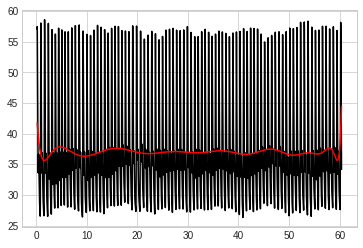

cleaning
3%
6%
9%
12%
16%
19%
22%
25%
29%
32%
35%
38%
42%
45%
48%
51%
54%
58%
61%
64%
67%
71%
74%
77%
80%
84%
87%
90%
93%
97%
100%


In [0]:
#values = heartRateForSubjects(19,20,0,4,True)

values = heartRateForFrames(1,2,1,2,True)


In [0]:
print(values[0][0].shape)

(15456,)


In [0]:
print(str(len(values)))

for l in values:
  print(str(len(l)))
  for value in l:
    print(len(value[1:-2]))
    print(statistics.mean(value[1:-2]))
    print(statistics.stdev(value[1:-2]))
    print(min(value[1:-2]))
    print(max(value[1:-2]))
    print("\n")

1
1
15805
85.06263341037325
13.16052783693
43.0
120.0




[[[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0]]]

subject 1 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


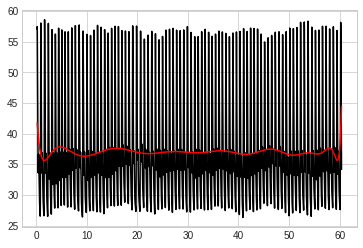

cleaning
100%

subject 2 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


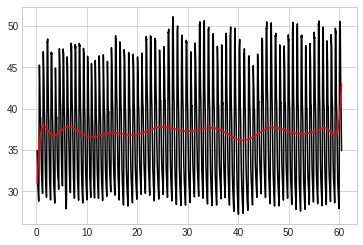

cleaning
100%

subject 3 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


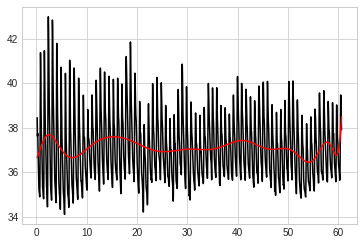

cleaning
100%

subject 4 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


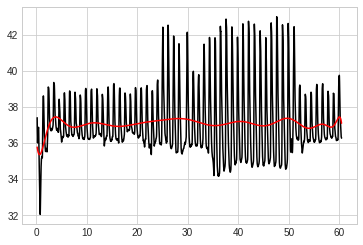

cleaning
100%

subject 5 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


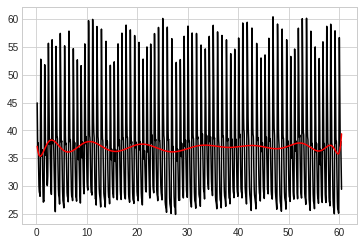

cleaning
100%

subject 6 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


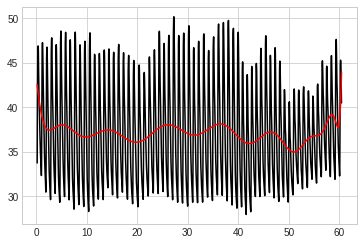

cleaning
100%

subject 7 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


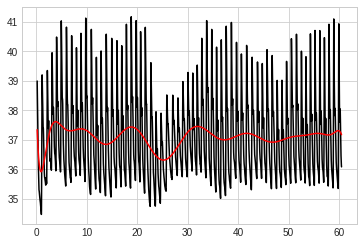

cleaning
100%

subject 8 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


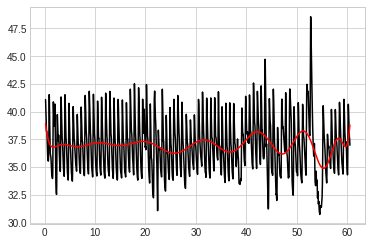

cleaning
100%

subject 9 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


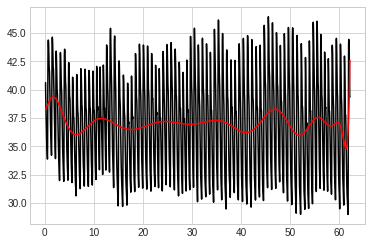

cleaning
100%

subject 10 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


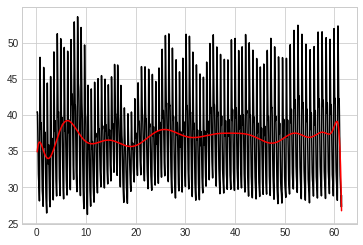

cleaning
100%

subject 11 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


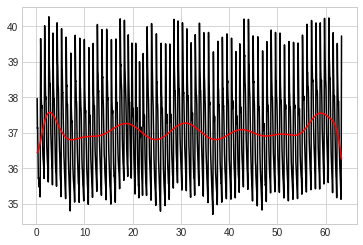

cleaning
100%

subject 12 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


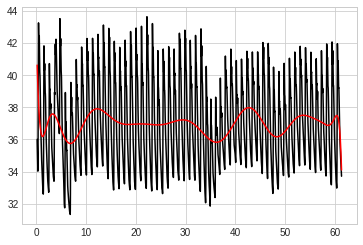

cleaning
100%

subject 13 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


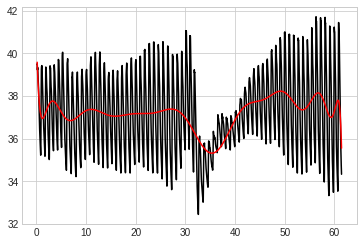

cleaning
100%

subject 14 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


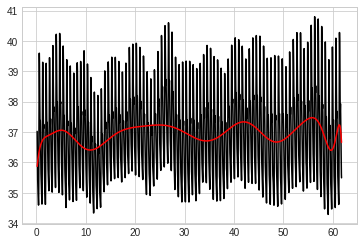

cleaning
100%

subject 15 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


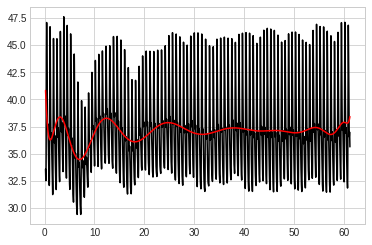

cleaning
100%

subject 16 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


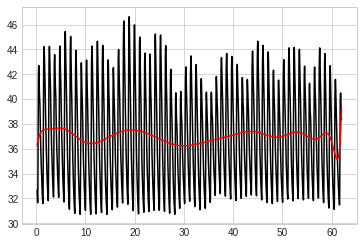

cleaning
100%

subject 17 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


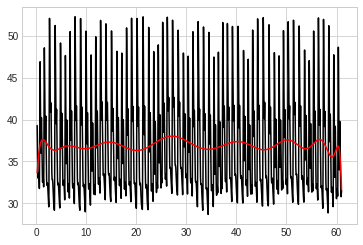

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars


cleaning
100%

subject 18 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


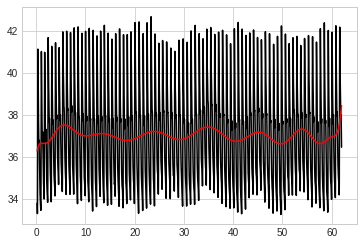

cleaning
100%

subject 19 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


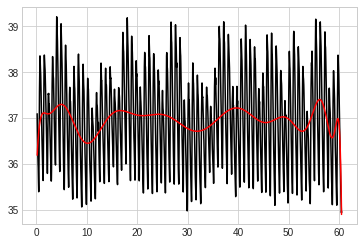

cleaning
100%

subject 20 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


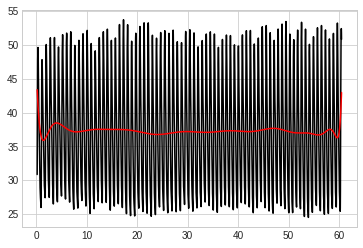

cleaning
100%

subject 21 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


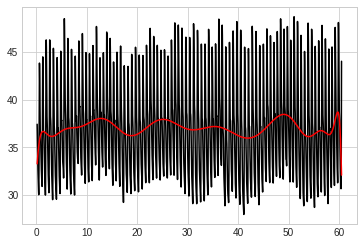

cleaning
100%

subject 22 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


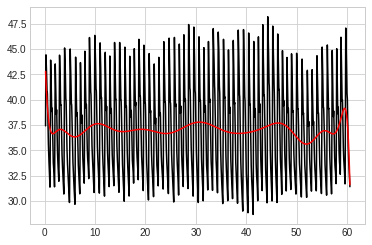

cleaning
100%

subject 23 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


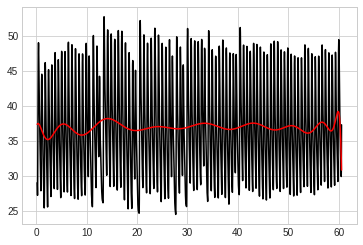

cleaning
100%

subject 24 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


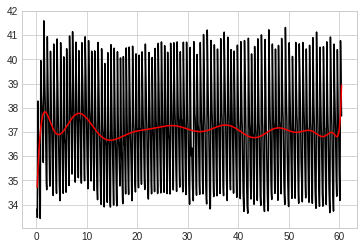

cleaning
100%

subject 25 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


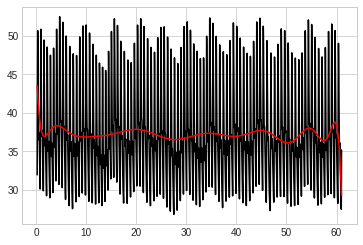

cleaning
100%

subject 26 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


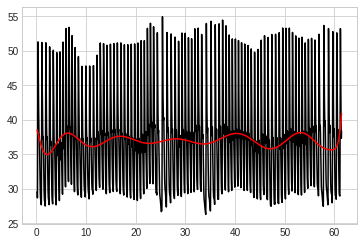

cleaning
100%

subject 27 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


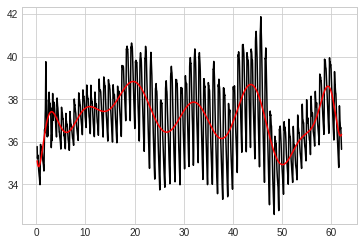

cleaning
100%

subject 28 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


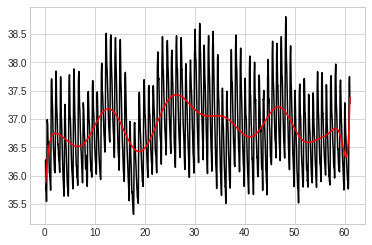

cleaning
100%

subject 29 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


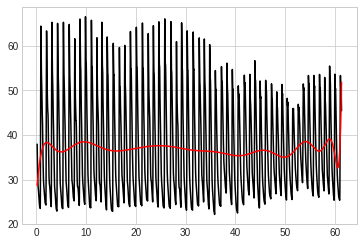

cleaning
100%

subject 30 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


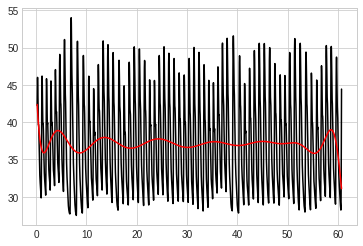

cleaning
100%

subject 31 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


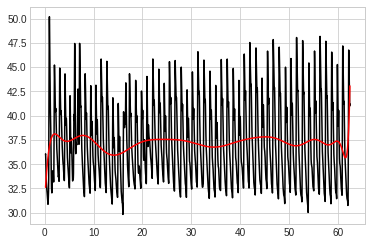

cleaning
100%

subject 32 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


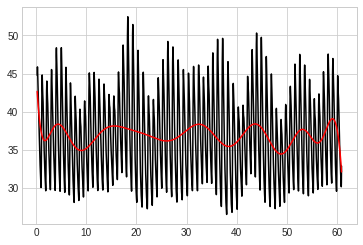

cleaning
100%

subject 33 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


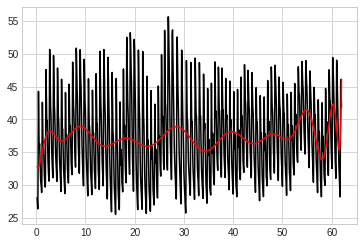

cleaning
100%

subject 34 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


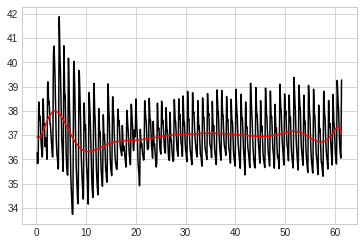

cleaning
100%

subject 35 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


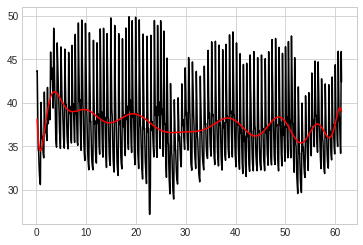

cleaning
100%

subject 36 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


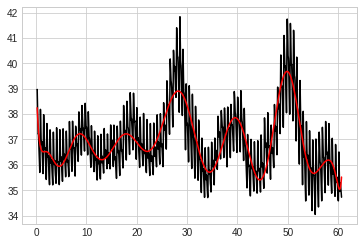

cleaning
100%

subject 37 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


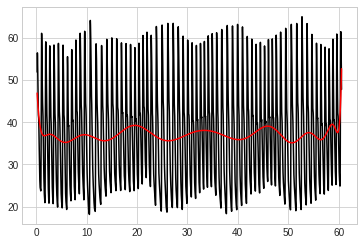

cleaning
100%

subject 38 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


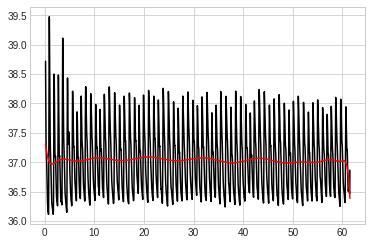

cleaning
100%

subject 39 set: 1
_________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


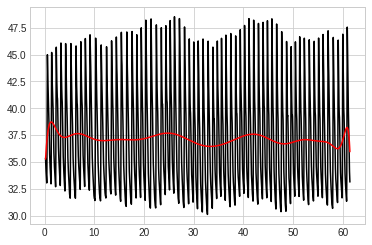

cleaning
100%


[[array([ 63., 134.,  69.,  67.,  65.,  64.,  64.,  63.,  63.,  59.,  56.,
          56.,  57.,  59.,  62.,  64.,  67.,  65.,  63.,  57.,  52.,  52.,
          53.,  54.,  55.,  57.,  59.,  60.,  62.,  60.,  59.,  56.,  54.,
          63.,  59.,  56.,  63.,  64.,  66.,  65.,  65.,  60.,  56.,  56.,
          56.,  58.,  60.,  62.,  65.,  67.,  70.,  69.,  69.,  64.,  60.,
          59.,  58.,  60.,  62.,  67.,  67.,  67.,  64.,  61.,  59.,  58.,
          59.,  61.,  64.,  68.,  69.,  71.,  67.,  63.,  60.,  60.,  60.,
          62.,  65.,  67.,  69.,  68.,  67.,  64.,  62.,  62.,  63.,  64.,
          66.,  68.,  67.,  67.,  64.,  62.,  60.,  58.,  59.,  60.,  62.,
          65.,  70.,  69.,  69.,  66.,  64.,  62.,  60.,  60.,  61.,  63.,
          66.,  67.,  63.,  59.,  63.,  60.,  57.,  58.,  60.,  65.,  65.,
          66.])],
 [array([ 63., 134.,  69.,  67.,  65.,  64.,  64.,  63.,  63.,  59.,  56.,
          56.,  57.,  59.,  62.,  64.,  67.,  65.,  63.,  57.,  52.,  52.,
       

In [0]:
heartRateForSubjects(folder_start=1,folder_end=2,plot=True)

### Dataloader

A potential data loader object

In [0]:
import h5py
import torch
import torch.utils.data as data

class HDF5Dataset(data.Dataset):

    def __init__(self, file_path):
        super(HDF5Dataset, self).__init__()
        h5_file = h5py.File(file_path)
        self.data = h5_file.get('data')
        self.target = h5_file.get('label')

    def __getitem__(self, index):            
        return (torch.from_numpy(self.data[index,:,:,:]).float(),
                torch.from_numpy(self.target[index,:,:,:]).float())

    def __len__(self):
        return self.data.shape[0]

#!cp 'gdrive/My Drive/cohface/1/0/data.hdf5' 'temp_video/test.hdf5'
dataset = HDF5Dataset('temp_video/test.hdf5')
print(dataset)

- First argument (mandatory) : random (0) or not random (1) 
- Second argument (mandatory) : the type of the video (avi, mp4, ...) 
- Third argument (mandatory) : number of videos wanted (if it's 0 or more than the amount of all the videos : all of them will be taken) 
- Other arguments : the list of directories or a directory that we want to look into

If there is a directory inside of the one given in the path it will be open as well.

If there isn't a path given, we will look in the current directory

In [0]:
script(0, 'avi', 2, '')

## Network

### Loss function



*   𝓁: loss
*   ϕ: concatenation of convolutional filter parameters
*   𝓣: labelled training set
*   SNR: Signal-To-Noise Ratio
*   PSD: Power Spectral Density
*   f: true HR
*   X: a sequence of N facial images






In [0]:
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
               "latest.js?config=default'></script>"))
Math(r'\ell(\mathcal{T};\phi) = -\frac{1}{l} \sum_{j=1}^{l} SNR(f^j,X^j;\phi)')

<IPython.core.display.Math object>

In [0]:
def PSD(f,X,Phi,h,fs=20):

  #f given frequency in Hz
  #X is set of images
  #Phi is filter parameters
  #h is extractor output
  #fs is sampling frequency in Hz

  f_hat = f/60

  N = X.size
  result1 = 0
  result2 = 0
  for n in range(0,N-1):
    result1 = result1 + h(X[n],Phi)*math.cos(2*math.pi*f_hat*n/fs)
    result2 = result2 + h(X[n],Phi)*math.sin(2*math.pi*f_hat*n/fs)

  return result1**2 + result2**2


In [0]:
def SNR(f,X,Phi,F,d,h):

  #f true hr
  #X set of images
  #Phi filter parameters
  #F is set of possible HR
  #d tolerance interval

  Fplus = list(filter(lambda x: x > f-d, F))
  Fplus = list(filter(lambda x: x < f+d, Fplus))

  Fminus = list(filter(lambda x: x < f-d, F))
  Fminus = list(filter(lambda x: x > f+d, Fminus))

  result1 = 0
  result2 = 0

  for i in range(0,len(Fplus)):
    result1 = result1 + PSD(Fplus[i],X,Phi,h)

  for i in range(0,len(Fminus)):
    result2 = result2 + PSD(Fminus[i],X,Phi,h)

  return 10*math.log10(result1/result2)


In [0]:
def loss_function(h,X,f,Phi,F,d=5):
  #X is a list of lists
  #f is the corresponding hr to a list in X
  result = 0
  print("Inside Loss function")
  print("shape of X: " + str(X.shape))
  l = len(X)

  for i in range(0,l):
    result = result + SNR(f[i],X[i],Phi,F,d,h)
    
  return -1/l * result

In [0]:
#Initiate set of possible heart rates
F = []
for(i in range(40,240)):
  F.append(i)

### Network definition

Implementation details Both networks use a standard chain of convolution, MaxPool and
activation functions. Before the first convolution layer and after every MaxPool layer, a
batch normalization was inserted. Exponential Linear Units [2] were used as the activation
functions. Dropout was used. Batch normalization was initialized with weights randomly
sampled from a Gaussian distribution with m = 0 and s = 0:1, convolution layers were
initialized according to the method described in [3]. Both network components were trained
using PyTorch library, Adam optimizer was used with learning rate set to 0:0001 in case of
the Extractor and to 0:1 in case of the HR estimator. For both training setups, a set of all input
facial RGB images X = R192128. Faces were found by a face detector, the bounding boxes
were adjusted to the aspect ratio 3 : 2 to cover the whole face, cropped out and resized to
192128 pixels. The set of true HR F = {40/60 ; 41/60; : : : ; 240/60} in case of extractor and F = R0+
in case of estimator.

In [0]:
class Extractor(nn.Module):
    
    def __init__(self,name='Extractor'):
        super(Extractor, self).__init__()
        self.T = 120
        
        self.name = name
        
        self.training_epochs = 0
        
        self.lr_history       = []
        self.accuracy_history = []
        self.loss_history     = []
        
        self.batchnorm0 = nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2D(3,64,(15,10),2,2,2)

        self.pooling1 = nn.MaxPool2d((15,10), stride=1, padding=1, dilation=2)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.pooling2 = nn.MaxPool2d((15,10), stride=1, padding=1, dilation=2)
        self.batchnorm2 = nn.BatchNorm2d(64)
        
        self.pooling3 = nn.MaxPool2d((15,10), stride=1, padding=1, dilation=2)
        self.batchnorm3 = nn.BatchNorm2d(64)

        self.fc = torch.nn.Linear(in_features=64*1*1, out_features=1)
      
        
        # robust weight initialization
        torch.nn.init.xavier_normal_(self.conv1.weight)
      

        
    def forward(self, x):

        # first set of CNNs and then a max pool
        x = self.batchnorm0(x)
        x = self.conv1(x)
        x = F.elu(x)
        x = self.pooling1(x)
        x = self.batchnorm1(x)
        x = self.pooling2(x)
        x = self.batchnorm2(x)
        x = self.pooling3(x)
        x = self.batchnorm3(x)
        
        batch_size, C, H, W = x.size()
        
        x = x.view(batch_size, H*W*C)

        x = F.elu(fc(x))
        
        return x
      
    def save(self,root='gdrive/My\ Drive/DeepLearning/Nets'):
      !mkdir $root
  
      path = root.replace('\\','') + '/' + self.name + '.pickle'
    
      print("\nsaving network under:\n",path)
      
      with open(path, 'wb') as f:
        pickle.dump(self, f)
        
    def next_epoch(self,lr,acc_hist,loss_hist):
      self.training_epochs += 1
      self.lr_history.append(lr)
      self.accuracy_history.append(acc_hist)
      self.loss_history.append(loss_hist)
    
    def reset(self):
      self.training_epochs = 0
      self.lr_history = []
      self.accuracy_history = []
      self.loss_history = []

### Network Training Methods

In [0]:
def get_cost_function():
    
  return loss_function
    
def get_optimizer(net, lr=0.0001, wd, momentum):
  optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=wd, amsgrad=False)
  return optimizer

In [0]:
def test(net, cost_function, device='cuda:0', start=0,end=16):
  samples = 0.
  sequences = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.
  cumulative_seq_accuracy = 0.

  seq = 200

  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  
  with torch.no_grad():
    t_data, t_labels
      
    #zero mean and normalize the data
    mean = t_data.mean()
    std  = t_data.std()
      
    t_data = (t_data - mean)/std
      
    # Load data into GPU
    inputs = t_data.float().to(device)
    targets = torch.LongTensor(t_labels).to(device)
      
    # Apply the loss (h,X,f,Phi,F,d=5)
    loss = cost_function(net,inputs,targets, net.parameters,F,d=5)

    cumulative_loss += loss
  
  
  return cumulative_loss/samples

In [0]:
def train(net, cost_function, device='cuda:0', start=0,end=16):
  samples = 0.
  sequences = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.
  cumulative_seq_accuracy = 0.

  seq = 200

  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  
  with torch.no_grad():
    t_data, t_labels
      
    #zero mean and normalize the data
    mean = t_data.mean()
    std  = t_data.std()
      
    t_data = (t_data - mean)/std
      
    # Load data into GPU
    inputs = t_data.float().to(device)
    targets = torch.LongTensor(t_labels).to(device)
      
    # Apply the loss (h,X,f,Phi,F,d=5)
    loss = cost_function(net,inputs,targets, net.parameters,F,d=5)

    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    # Reset the optimizer
    optimizer.zero_grad()

    cumulative_loss += loss
  
  
  return cumulative_loss/samples

* Video Visualization of the Face color

* Results for CNN

* send the specification of delivery